# How to use combine unity and scanimage data? 

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import scipy.signal
from scipy.stats import vonmises, skew, kurtosis
import json
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from ScanImageTiffReader import ScanImageTiffReader

from fly2p.viz.viz import myAxisTheme
from fly2p.preproc.scanImageUtils import getSIbasicMetadata, getSIMetadict, loadvolume
from unityvr.analysis.align2img import generateUnityExpDf, truncateImgDataToUnityDf, addImagingTimeToUvrDat, addImagingTimeToSceneArr
import fly2p.preproc.imgPreproc as imp

from unityvr.preproc import logproc as lp
from unityvr.viz import viz
from unityvr.analysis import posAnalysis, shapeAnalysis, fitting, utils

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

import matplotlib

matplotlib.rcParams['animation.embed_limit'] = 2**128


# Extract imaging data as an xarray

In [2]:
dirName = '../sample/sample2/'
fileNameSI = 'SS96-x-6f-Shi_f01_9-10d_EB_panA2s_00003.tif'
mytiffreader = ScanImageTiffReader(dirName+fileNameSI)
imgMetadat = getSIbasicMetadata(mytiffreader.metadata())
imgMetadat["CaCh"] = 0 # give channel identity
SImetadict = getSIMetadict(mytiffreader.metadata())


stack = loadvolume(dirName+fileNameSI, imgMetadat, selectCaChan=True)
imgStack = imp.stack2xarray(stack, imgMetadat)
print(imgMetadat)

SI.VERSION_COMMIT = '5066720ab90fa5f9bfc89c972f39266d0afd7c49'
SI.VERSION_MAJOR = 2022
SI.VERSION_MINOR = 1
SI.VERSION_UPDATE = 0
{'nCh': 1, 'fpsscan': 80.7143, 'discardFBFrames': 'true', 'nDiscardFBFrames': 2, 'fpv': 9, 'nVols': 2697, 'stackZStepSize': 2.5, 'scanVolumeRate': 8.96825, 'fovCoords': {'p00': [-18.75, -18.75], 'p10': [18.75, 18.75], 'p01': [18.75, -18.75], 'p11': [-18.75, 18.75]}, 'xrange_um': 37.5, 'yrange_um': 37.5, 'CaCh': 0}


Decide if you want to use napari to visualize data

In [3]:
useNapari = True

In [4]:
if useNapari: 
    import napari 
    napari.view_image(imgStack)

## Constructing unityvr data object from log file

In [7]:
fileNameUVR = 'Log_2024-07-11_18-46-08_SS96-x-6f-Shi_f01_EB_panA2s_t03.json'

In [8]:
uvrDat = lp.constructUnityVRexperiment(dirName, fileNameUVR, fictracSubject='Not Integrated', posDfKey = 'attemptedTranslation')
#if using FictracSubjectIntegrated, set fictracSubject='Integrated' and posDfKey = 'worldPosition'
#posDfKey specifies the string that will be matched to find the chunk in the json that contains position data. For FictracSubjectIntegrated this is expected to be 'worldPosition', while for FictracSubject it is expected to be 'attemptedTranslation'.
uvrDat.printMetadata()

correcting for Unity angle convention.
Metadata:

expid  :  SS96-x-6f-Shi_panA2s
experiment  :  holder V2, closed loop panorama, 144 Hz frame rate, collected by Shivam
genotype  :  SS96-x-6f-Shi
sex  :  f
flyid  :  f01
trial  :  trial03
date  :  2024-07-11
time  :  18-46-08
ballRad  :  0.04699999839067459
setFrameRate  :  144
notes  :  EB imaging
angle_convention  :  right-handed


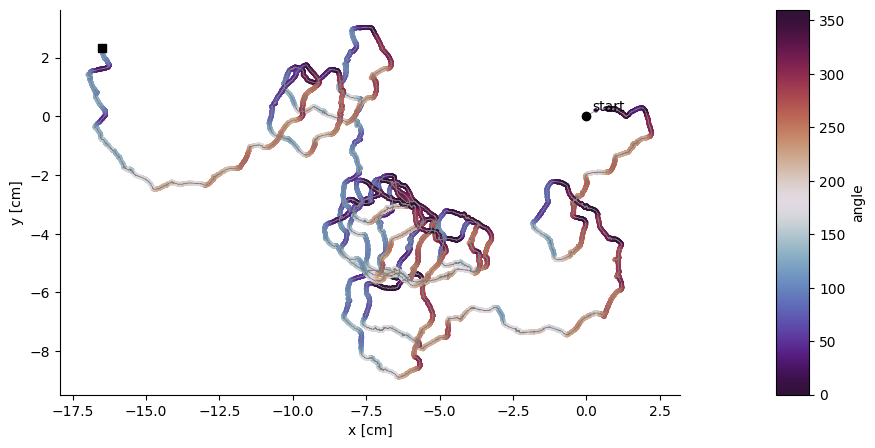

In [9]:
posAnalysis.position(uvrDat, plot=True, rotate_by = 90);
#uvrDat is mutable, so the position data is now stored in uvrDat.posDf

# Alignment

To align SI and UVR data, we need 
- `basicMetadat`: metadata from the scanimage file, 
- `imgStack['volumes [s]']`: a timeseries for each imaging volume and 
- `uvrDat`: the uvrDat class object extracted from the log file

uvrDat contains `niDf` which has the frame clock signal from SI as a time series. Unity holds these values in buffer and dumps them for each frame, such that many frame clock values exist per unity frame. We use the dips in the frame clock signal to extract when each SI frame was collected. The beginning of each volume is determined by figuring out the unity time for every nth scanimage frame where n is extracted from SI metadata (n includes flyback frames and thus accounts for it). The logged unity value at the beginning of each scanimage volume can thus be extracted and the scanimage time (volumes [s]) can then be attached to this value. 

### Sanity Check 1:
The plot below shows the unity frame clock signal as a time series for an arbitrary chunk of time in the trial. If the red dots align with the dip in the signal, then the dips are being detected correctly. 

### Sanity Check 2:
Aligns the unity time with the scanimage time to see how different the values are: if scanimgae and unity start together (as they should if unity triggers scanimage acquisition), then the plot should resemble the 45° line. 

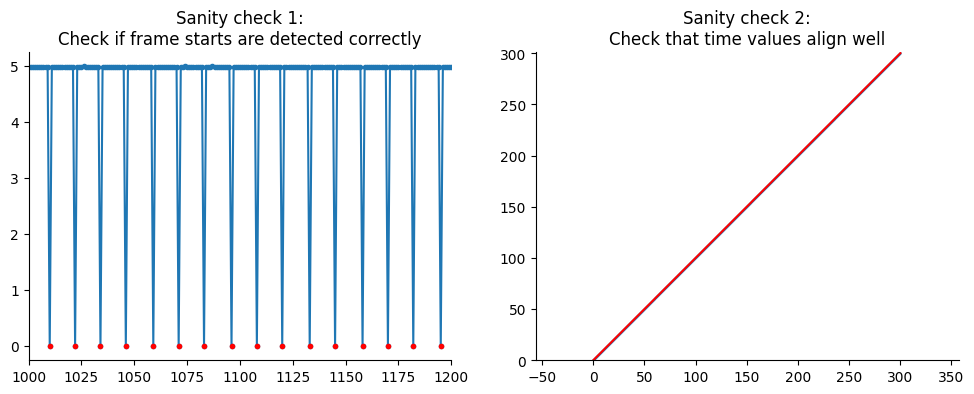

In [10]:
expDf = generateUnityExpDf(imgStack['volumes [s]'].values, uvrDat, imgMetadat);

`expDf` is now downsampled and contains values only from unity frames that were displayed at the beginning of each SI volume. 

**IMPORTANT**: remember to derive quantities (like speed and acceleration) before downsampling the unity values to SI rate to achieve greater accuracy (unity is >10x faster than imaging).

In [11]:
expDf.head()

,frame,time,dt,x,y,angle,dx,dy,dxattempt,dyattempt,ds,s,dTh,radangle,vT,vR,vT_filt,vR_filt,volumes [s]
1,316.0,0.333333,0.333333,0.001138,0.001022,85.976260,0.001205,0.000672,0.001205,0.000672,0.001380,0.001756,-3.152619,1.500569,0.566663,1.886051,29.050821,0.583617,0.000000
12,327.0,0.370201,0.006932,0.075159,0.023867,350.806877,0.000025,0.000108,0.000025,0.000108,0.000111,0.082801,0.348602,-0.160450,0.282671,0.374771,0.044036,0.192791,0.111504
32,347.0,0.482950,0.006937,0.073832,0.027402,359.143814,-0.000512,-0.000332,-0.000512,-0.000332,0.000610,0.091845,0.668930,-0.014943,0.400820,0.040115,0.517530,0.125460,0.223009
48,363.0,0.594064,0.006934,0.075271,0.026423,358.501709,0.000553,0.000209,0.000553,0.000209,0.000591,0.100161,-1.967941,-0.026150,0.426370,-0.054752,0.626879,0.207707,0.334513
64,379.0,0.705179,0.006939,0.076815,0.028054,1.297325,0.000037,-0.000152,0.000037,-0.000152,0.000156,0.108610,0.339424,0.022643,0.029637,-0.004936,0.419703,0.001943,0.446018


In some situations it is useful to modify the uvrDat class object to contain the _interpolated_ SI time. An example of this is if we would like to derive quantities such as speed or acceleration or if one would like to account for multiple unity frames before the volume was collected instead of the unity frame just before the volume was collected. 

**USEFUL**: uvrDat is mutable. 

In [13]:
addImagingTimeToUvrDat(imgStack['volumes [s]'].values, uvrDat, imgMetadat, generateExpDf_params={'suppressDepugPlot':True});

In [14]:
uvrDat.posDf.head()

,frame,time,dt,x,y,angle,dx,dy,dxattempt,dyattempt,ds,s,dTh,radangle,vT,vR,vT_filt,vR_filt,volumes [s]
0,315.0,0.000000,0.006938,-0.000077,0.000368,89.128879,-0.000077,0.000368,-0.000077,0.000368,0.000376,0.000376,0.000000,1.555592,1.988635,3.130566,-8.323989,3.624041,-0.010137
1,316.0,0.333333,0.333333,0.001138,0.001022,85.976260,0.001205,0.000672,0.001205,0.000672,0.001380,0.001756,-3.152619,1.500569,0.566663,1.886051,29.050821,0.583617,0.000000
2,317.0,0.339101,0.005768,0.031952,0.020400,23.785942,0.029378,0.021493,0.029378,0.021493,0.036401,0.038157,-62.190318,0.415143,59.422846,-0.997005,43.839027,-0.471860,0.010137
3,318.0,0.342342,0.003241,0.064742,0.026574,354.159218,0.007575,0.032494,0.007575,0.032494,0.033366,0.071522,-29.626724,-0.101941,58.213764,-1.338754,41.959928,-0.284491,0.020274
4,319.0,0.345181,0.002838,0.069507,0.024134,354.117256,0.001942,0.004989,0.001942,0.004989,0.005354,0.076876,-0.041962,-0.102673,17.220628,1.095061,32.434086,0.006544,0.030410


Sometimes, the unity trial ends before scanimage and the imaging data needs to be truncated to achieve the same length as `expDf`. 

In [15]:
imgStack = truncateImgDataToUnityDf(imgStack, expDf)

## Sample plot for visualizing imaging and unity data

In [16]:
%%capture
i = 0
fig, ax = plt.subplots(2,1, figsize = (5,5), height_ratios=[5,1])
maxProj = imgStack.max(axis = 1)
im = ax[0].imshow(maxProj[i], vmin=200, vmax = 500)
ax[0].axis('off');

line, = ax[1].plot([expDf['angle'].values[i], expDf['angle'].values[i]], [0,1], color = 'w')
ax[1].set_xticks([])
ax[1].set_yticks([]);
ax[1].set_facecolor('k')
ax[1].set_xlim(0,360);
ax[1].set_ylim(0,1);

def animate(i):
    im.set_array(maxProj[i])
    line.set_xdata([expDf['angle'].values[i], expDf['angle'].values[i]]);

In [ ]:
ani = FuncAnimation(fig, animate, interval=100, frames=len(imgStack))
HTML(ani.to_jshtml())